## 1. How do countries differ in healthcare financing, and what does this imply for out-of-pocket spending?
### a) Do high-spending or high-income countries show lower OOP burdens?
### b) Do outliers matter?

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------
'''If you have multiple virtual environments setup on your system, before installing any dependencies it is important to 
   verify location of virtual environmnet jupyter notebook is running on to ensure the dependencies are installed on the same
   location'''
# ----------------------------------------------------------------------------------------------------------------------------
import sys
print(sys.executable)

In [ ]:
# -----------------------------------------------------------
'''installing api clients/ dependencies''' 

'''DO NOT RUN THIS BLOCK IS DEPENDENCIES ALREADY INSTALLED'''

'''BEFORE RUNNING THE CODE CHANGE THE PATH TO ALIGN 
   WITH THE venv OF YOUR JUPYTER NOTEBOOK'''
# -----------------------------------------------------------

#!{sys.executable} -m pip install wbgapi
#!{sys.executable} -m pip install pandasdmx
#!pip install requests-cache
!C:\Users\User\anaconda3\python.exe -m pip install --force-reinstall "wbgapi"
!C:\Users\User\anaconda3\python.exe -m pip install --force-reinstall "pydantic<2.0" pandasdmx==1.1.0
!C:\Users\User\anaconda3\python.exe -m pip install --force-reinstall "requests-cache"
!C:\Users\User\anaconda3\python.exe -m pip install --force-reinstall "pycountry"
!C:\Users\User\anaconda3\python.exe -m pip install --force-reinstall "linearmodels"

In [4]:
# api clients
import wbgapi as wb
from pandasdmx import Request
import requests

# Data Wrangling dependencies
import pandas as pd
import numpy as np
import pycountry

# Data Visualization dependencies
import matplotlib.pyplot as plt
import seaborn as sns

# stats dependencies
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.iv import IV2SLS , IVGMM
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from linearmodels.iv import IVGMMCUE      # efficient GMM (if required)
from linearmodels.panel import compare

In [5]:
# check if you are able to connect to the api
print("wbgapi OK:", list(wb.economy.list('USA'))[:3])
oecd = Request('OECD')
print("pandasdmx OK: dataflows loaded")

wbgapi OK: [{'id': 'USA', 'value': 'United States', 'aggregate': False, 'longitude': -77.032, 'latitude': 38.8895, 'region': 'NAC', 'adminregion': '', 'lendingType': 'LNX', 'incomeLevel': 'HIC', 'capitalCity': 'Washington D.C.'}]
pandasdmx OK: dataflows loaded


In [6]:
economies_all = pd.DataFrame(wb.economy.list())
economies_all.head()
economies_all.columns

Index(['id', 'value', 'aggregate', 'longitude', 'latitude', 'region',
       'adminregion', 'lendingType', 'incomeLevel', 'capitalCity'],
      dtype='object')

**OECD (Organization for Economic Co-operation and Development)** is a group of **38 countries** democratic political systems, that are **market-based economies**. These countries share their data to combat and develop common approaches to challenges like - Taxation, Education, Health care, Environmental protection, Trade and investment.

**Indicators:**

1. **SH.XPD.OOPC.CH.ZS** (Out Of Pocket Expenses on Health Care) - It is the amount of money directly paid by the household. It can also be interpreted                                                                     as the financial burden of health care on the husehold.
2. **NY.GDP.PCAP.KD** (GDP per capita) - Income per person after controlling for infation.
3. **SH.XPD.CHEX.GD.ZS** - Government health expenditure as a % of their GDP. The fraction of national output allocated by the government to health —                               not total health spending, only the public portion. Essentially, this variable captures the policy effort behind health                                  financing — it’s the supply-side financing capacity that offsets household-level payments.
4. <span style =" color: red">**SH.UHC.SRVS.CV.XD**</span>- (UHC_service_coverage)It is an indexed representation of how many essential health services are actually available and                                   delivered across dimensions such as:maternal and child services, communicable disease control, non-communicable disease                                  treatment, financial and access coverage, service availability and readiness.
                           This is not expenditure — it's outcome-side availability and coverage. <span style =" color: red">**- depricated**</span>

In [44]:
# List of OECD countries based on iso3 naming convention
oecd_economies = [
    'AUS','AUT','BEL','CAN','CHL','COL','CZE','DNK','EST','FIN','FRA','DEU',
    'GRC','HUN','ISL','IRL','ISR','ITA','JPN','KOR','LVA','LTU','LUX','MEX',
    'NLD','NZL','NOR','POL','PRT','SVK','SVN','ESP','SWE','CHE','TUR','GBR','USA'
]

# Selected Indicators from world bank api
wb_indicators = {
    "OOP_pct": "SH.XPD.OOPC.CH.ZS",
    "GDP_pc": "NY.GDP.PCAP.KD",
    "Gov_health_pct_gdp": "SH.XPD.CHEX.GD.ZS",
#   "UHC_service_coverage": "SH.UHC.SRVS.CV.XD", # depricated
#   "SH.UHC.SRVS.CV.ZS": "UHC_service_coverage"
}

# Pulling raw data for a time period of 2000 - 2025
df_raw = wb.data.DataFrame(
    list(wb_indicators.values()),
    economy=oecd_economies,
    time=range(2000, 2025) # year range
)

df_raw = df_raw.reset_index()

print("Returned columns:", df_raw.columns.tolist())
print(df_raw.head())
df_raw['series'].unique()

Returned columns: ['economy', 'series', 'YR2000', 'YR2001', 'YR2002', 'YR2003', 'YR2004', 'YR2005', 'YR2006', 'YR2007', 'YR2008', 'YR2009', 'YR2010', 'YR2011', 'YR2012', 'YR2013', 'YR2014', 'YR2015', 'YR2016', 'YR2017', 'YR2018', 'YR2019', 'YR2020', 'YR2021', 'YR2022', 'YR2023', 'YR2024']
  economy             series        YR2000        YR2001        YR2002  \
0     AUS     NY.GDP.PCAP.KD  45859.516210  46191.314237  47486.278322   
1     AUS  SH.XPD.CHEX.GD.ZS      7.588691      7.673917      7.872210   
2     AUS  SH.XPD.OOPC.CH.ZS     20.997139     20.439098     19.920012   
3     AUT     NY.GDP.PCAP.KD  38571.085878  38929.753801  39313.722511   
4     AUT  SH.XPD.CHEX.GD.ZS      9.203713      9.269429      9.394765   

         YR2003        YR2004        YR2005        YR2006        YR2007  ...  \
0  48394.126948  49902.018702  50853.197673  51553.968597  52531.761120  ...   
1      7.876595      8.082577      7.964863      7.971611      8.051715  ...   
2     19.147589     19.21

array(['NY.GDP.PCAP.KD', 'SH.XPD.CHEX.GD.ZS', 'SH.XPD.OOPC.CH.ZS'],
      dtype=object)

In [45]:
# The raw data has years as columns. It needs to be at row level
# List of all the year column heads
year_cols = [c for c in df_raw.columns if c.startswith("YR")]

# melting (unpivoting)
df_long = df_raw.melt(
    id_vars=["economy", "series"],
    value_vars=year_cols,
    var_name="year",
    value_name="value"
)

# removing the "YR" substring from the year values and typecasting it to integers
df_long["year"] = df_long["year"].str.replace("YR", "").astype(int)

# pivoting
df_panel = df_long.pivot_table(
    index=["economy", "year"],
    columns="series",
    values="value"
).reset_index()

# adding descriptive name to indicators
indicator_names = {
    "SH.XPD.OOPC.CH.ZS": "OOP_pct",
    "NY.GDP.PCAP.KD": "GDP_pc",
    "SH.XPD.CHEX.GD.ZS": "Gov_health_pct_gdp"
}
# Note: "UHC_service_coverage" indicator is  now obsolete after 4th Dec.
# I initially started out with this variable and was working fine, but recently around 4th dec the world bank has made some cahnges to this indicator
# and it now seem to exist with a different name
'''
rename_map = {
    "SH.XPD.OOPC.CH.ZS": "OOP_pct",
    "NY.GDP.PCAP.KD": "GDP_pc",
    "SH.XPD.CHEX.GD.ZS": "Gov_health_pct_gdp",
    "SH.UHC.SRVS.CV.XD": "UHC_service_coverage", # depricate after ~4th Dec.
}
'''
df_panel = df_panel.rename(columns=indicator_names)

# Step 6 — keep only needed columns
# df_final = df_panel[["economy", "year", "OOP_pct", "GDP_pc", "Gov_health_pct_gdp", "UHC_service_coverage"]] # changes made after deprication of indicator
df_panel.columns = [c.lower() for c in df_final.columns] # ensure lower case names
# making a copy of panel data before working on it.
df_final = df_panel.copy()
df_final.head(), df_final.columns

(  economy  year       oop_pct    gdp_pc  gov_health_pct_gdp
 0     AUS  2000  45859.516210  7.588691           20.997139
 1     AUS  2001  46191.314237  7.673917           20.439098
 2     AUS  2002  47486.278322  7.872210           19.920012
 3     AUS  2003  48394.126948  7.876595           19.147589
 4     AUS  2004  49902.018702  8.082577           19.218697,
 Index(['economy', 'year', 'oop_pct', 'gdp_pc', 'gov_health_pct_gdp'], dtype='object'))

## Exporting extracted Data

In [46]:
# exporting raw panel data
df_final.to_csv("oecd_health_panel_raw.csv", index=False)

## Exploratory Data Analysis 

In [47]:
# validating columns for null values
df_final.head()
df_final.isna().mean()

economy               0.000000
year                  0.000000
oop_pct               0.000000
gdp_pc                0.059524
gov_health_pct_gdp    0.059524
dtype: float64

In [52]:
# Dimentionality check
df_final.shape

(924, 5)

In [48]:
# drop missing variables
df = df_final.copy() # create a copy of the raw dataset before any transforamtion
#df.drop("uhc_service_coverage", axis = 1, inplace = True) # Indicator depricated
# dropping null values
df = df.dropna(subset=["oop_pct", "gov_health_pct_gdp"])
df.isna().mean()

economy               0.0
year                  0.0
oop_pct               0.0
gdp_pc                0.0
gov_health_pct_gdp    0.0
dtype: float64

In [54]:
# reduced rows after dropping null values
df.shape

(869, 5)

In [55]:
# grouping data based on countries and year
df.groupby("economy")["year"].count().sort_values()

economy
AUS    23
BEL    23
CHE    23
GRC    23
FIN    23
FRA    23
ESP    23
EST    23
LVA    23
MEX    23
NLD    23
NOR    23
NZL    23
JPN    23
ISR    23
IRL    23
TUR    23
USA    23
SVK    23
GBR    24
CAN    24
DEU    24
DNK    24
AUT    24
LTU    24
KOR    24
ITA    24
ISL    24
HUN    24
CHL    24
COL    24
CZE    24
PRT    24
POL    24
LUX    24
SVN    24
SWE    24
Name: year, dtype: int64

In [50]:
# validate the data-type of the indicators
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 869 entries, 0 to 921
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   economy             869 non-null    object 
 1   year                869 non-null    int64  
 2   oop_pct             869 non-null    float64
 3   gdp_pc              869 non-null    float64
 4   gov_health_pct_gdp  869 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 40.7+ KB


**Univariate Analysis** - to understand the behaviour each indicators individually

In [27]:
# data summary
summary = df[['oop_pct','gdp_pc','gov_health_pct_gdp']].describe().T
summary['skew'] = df[['oop_pct','gdp_pc','gov_health_pct_gdp']].skew().values
summary


,count,mean,std,min,25%,50%,75%,max,skew
oop_pct,869.0,20.518214,9.243092,7.137969,13.745366,18.016603,24.599552,55.663651,1.219222
gdp_pc,869.0,35016.896367,22271.032207,4016.809517,16576.715884,34372.589109,45973.553768,112417.876989,1.029661
gov_health_pct_gdp,869.0,8.461474,2.225073,3.703389,6.828302,8.353586,9.920691,18.813253,0.785468


Most countries allocate 4–8% of GDP to healthcare, which forms the main part of the distribution. A small group of richer or welfare-oriented countries spend above 15%, creating a right skew. These cases likely reflect stronger public systems, ageing populations, or greater fiscal capacity. Overall, most economies spend modestly, with only a few outliers at much higher levels.

GDP per capita is tightly centred, with mean and median close, indicating that most countries fall within the middle-income range. The distribution is right-skewed because a small group sits far above typical income levels. Around 75% of countries lie below roughly 46K, while a small cluster forms a distinct high-income group. These outliers reflect structurally different economies with greater fiscal and institutional capacity, which likely shapes their healthcare financing and out-of-pocket patterns.

Most countries spend between 4% and 8% of GDP on government health, while a small group spends above ~15%, producing a right-skewed distribution. These high percentages do not necessarily indicate high absolute spending, as smaller economies may allocate more due to structural inefficiencies, ageing populations, or limited private-sector provision.

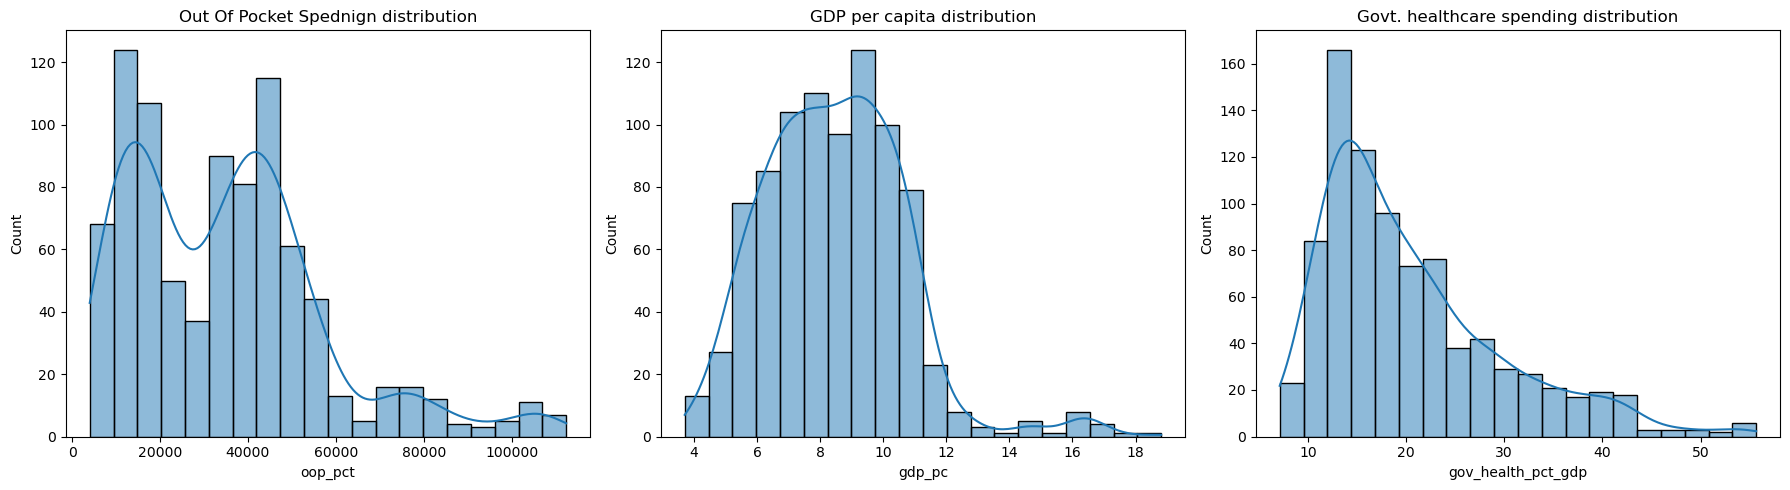

In [59]:
# histogram of each variable to study skewness
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.histplot(df['oop_pct'].dropna(), bins=20, kde=True)
plt.title('Out Of Pocket Spednign distribution')

plt.subplot(1,3,2)
sns.histplot(df['gdp_pc'].dropna(), bins=20, kde=True)
plt.title('GDP per capita distribution')

plt.subplot(1,3,3)
sns.histplot(df['gov_health_pct_gdp'].dropna(), bins=20, kde=True)
plt.title('Govt. healthcare spending distribution')

plt.tight_layout()


1. All three indicators show positive skewness.
2. Out of pocket spending(oop_pct distibution) shows that most economies have low out of pocket spending, and are only fewer economies that have very high out of pocket spending. Most countries have a Out-of-pocket spending between **~14%** - **~25%**, only few countries have spending around **~56%**. The outliers are causing a long right tail with Mean > Median, indicating a positively skewed distribution.
3. Most economies have GDP per capita around **~16.5k** to  **~46k**, only a few reach as high as **112.5k** resulting in right skewness of the sample distribution. 
4. Most countries can be seen to have a Govt. health care spending between **~6.8%** - **~8.3%**, only a few economies have a higher spending percentage i.e. **~19%** generating long right tail and positively skewed distribution.

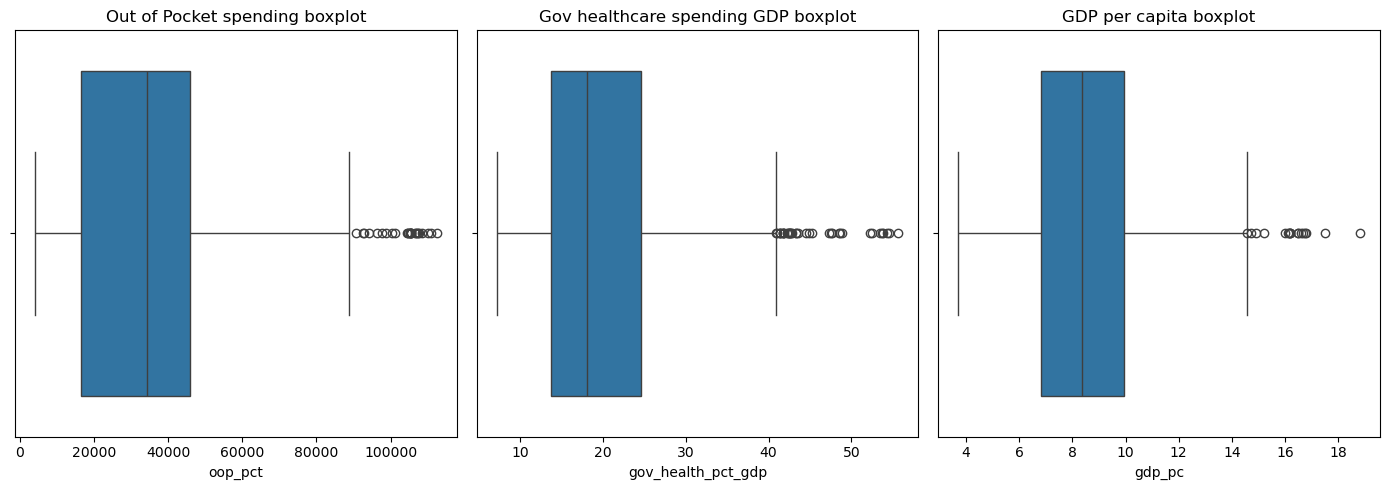

In [61]:
# boxplot for studying outliers
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
sns.boxplot(x='oop_pct', data=df)
plt.title('Out of Pocket spending boxplot')

plt.subplot(1,3,2)
sns.boxplot(x='gov_health_pct_gdp', data=df)
plt.title('Gov healthcare spending GDP boxplot')
plt.tight_layout()

plt.subplot(1,3,3)
sns.boxplot(x='gdp_pc', data=df)
plt.title('GDP per capita boxplot')
plt.tight_layout()

The box plots clearly give us an idea of the outlier values in each sample.
1. Out of pocket spending for most countries is between ~14% to ~25% with a median of 18% indicating half of economies having spending less than that.Only a few countries have disproportionately high out-of-pocket spending clustering around 42% to 56%, leading to a positive skewness.
2. The Govt. health care spending for most countries is around ~6% to ~10%, the median ~8.3% indicating half of economies having a govt. health care spending less than this value. Some economies can be observed to have a very high spending close to ~14.5% to ~18.5%, causing positive skewness.
3. Most of the economies have GDP per capita around ~18k to ~45k with half of the total OECD economy having GDP per capita less than ~38k. Only a few exceptionally well-off economies can be observed to have very high per capita GDP ~85k to ~110K, creating a positive skewness.

**Bivariate Analysis** - to undersatnd the behaviour of other indicator in context to our dependent variable oop_pct

In [62]:
# correlation matrix
corr = df[['oop_pct','gdp_pc','gov_health_pct_gdp']].corr()
print(corr)

                     oop_pct    gdp_pc  gov_health_pct_gdp
oop_pct             1.000000  0.411059           -0.482409
gdp_pc              0.411059  1.000000           -0.450346
gov_health_pct_gdp -0.482409 -0.450346            1.000000


The **moderately negative co-relation for both GDP per capita(-0.48) and Govt. health care spending as a share of GDP(-0.45)** with out-of-pocket spending suggest that rich economies or the economies with high govt. health care spending place low burden on out-of-pocket spending of their citizens.
Additionally the **positive co-relation between GDP per capita and Govt. health care spending indicator(0.41)** suggest that rich economies tend to spend higher on Govt. health care policies.

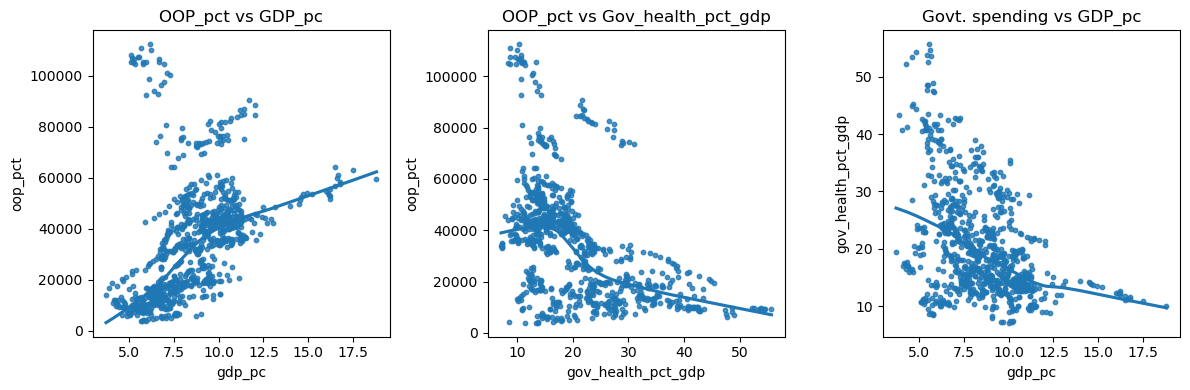

In [64]:
# Scatter plot with LOWESS
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.regplot(x='gdp_pc', y='oop_pct', data=df, scatter_kws={'s':10}, lowess=True)
plt.title('OOP_pct vs GDP_pc')

plt.subplot(1,3,2)
sns.regplot(x='gov_health_pct_gdp', y='oop_pct', data=df, scatter_kws={'s':10}, lowess=True)
plt.title('OOP_pct vs Gov_health_pct_gdp')

plt.subplot(1,3,3)
sns.regplot(x='gdp_pc', y='gov_health_pct_gdp', data=df, scatter_kws={'s':10}, lowess=True)
plt.title('Govt. spending vs GDP_pc')
plt.tight_layout()


**oop_pct vs gdp_pc** : Smaller economies tend to have higher Out-of-pocket spending. The relationship appears negative, but it is not strictly linear. The decline in OOP with increasing GDP slows down after a point, suggesting diminishing marginal effect of income on household medical spending.

**oop_pct vs gov_health_pct_gdp** : Higher Government spending on healthcare is associated with lower Out-of-pocket spending. The trend is visibly stronger compared to GDP per capita, although still not perfectly linear. This implies that direct government intervention impacts household spending more than income levels do.

**gdp_pc vs gov_health_pct_gdp** : The relationship is clearly non-linear. Government healthcare spending increases with GDP up to around ~50K, after which it begins flattening. Beyond a certain income level, additional increase in GDP does not increase public spending proportionally, indicating diminishing allocation of GDP to public healthcare in richer countries.

In [32]:
# Baseline model
model_base = smf.ols(
    "oop_pct ~ gdp_pc + gov_health_pct_gdp",
    data=df
).fit()

print(model_base.summary())


                            OLS Regression Results                            
Dep. Variable:                oop_pct   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     193.8
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.82e-70
Time:                        00:36:56   Log-Likelihood:                -3004.4
No. Observations:                 869   AIC:                             6015.
Df Residuals:                     866   BIC:                             6029.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             36.3779      1

Both GDP per capita and government health spending are highly significant, with large t-values and near-zero p-values. Each coefficient is negative, indicating that higher income and greater public spending reduce out-of-pocket costs. Government spending shows the stronger effect, consistent with expanded public financing lowering household burden. The model explains around 31% of variation in OOP spending, which is reasonable for macro data but leaves substantial unexplained factors. The baseline assumes a constant income effect, whereas the log specification recognises diminishing marginal returns as countries become richer and provides a more meaningful interpretation.

In [67]:
# OLS with log of GDP
df["log_gdp_pc"] = np.log(df["gdp_pc"])

model_log = smf.ols(
    "oop_pct ~ log_gdp_pc + gov_health_pct_gdp",
    data=df
).fit()

print(model_log.summary())


                            OLS Regression Results                            
Dep. Variable:                oop_pct   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     168.1
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.10e-62
Time:                        08:03:14   Log-Likelihood:                -9789.6
No. Observations:                 869   AIC:                         1.959e+04
Df Residuals:                     866   BIC:                         1.960e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           9729.5137   6727

Two models were estimated. The baseline uses GDP per capita, while the extended model uses its logarithm. The baseline fits slightly better (R² 0.309 vs. 0.304), and the adjusted values show the same pattern. In both cases, higher income and greater government spending reduce out-of-pocket expenditure, and the coefficients remain negative and highly significant. The log transformation mainly affects interpretation and does not materially change model performance.

In [65]:
# Breusch-Pagan test (heteroscedasticity check)
bp_test = het_breuschpagan(model_log.resid, model_log.model.exog)
bp_test

(np.float64(216.60737534740753),
 np.float64(9.210984967700227e-48),
 np.float64(143.76464414411856),
 np.float64(1.2213841263450597e-54))

The Breusch–Pagan test confirms heteroscedasticity. The LM statistic (216.607, p = 0.009) and the F statistic (143.764, p = 0.001) both reject constant variance. The error variance changes across observations, so inference relies on heteroscedasticity-robust standard errors.

In [68]:
# heteroscedasticity fix
model_log_robust = model_log.get_robustcov_results()
print(model_log_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                oop_pct   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     469.8
Date:                Wed, 10 Dec 2025   Prob (F-statistic):          6.59e-139
Time:                        08:05:03   Log-Likelihood:                -9789.6
No. Observations:                 869   AIC:                         1.959e+04
Df Residuals:                     866   BIC:                         1.960e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           9729.5137   1.12

After the Breusch–Pagan test indicated heteroscedasticity, the model was re-estimated with robust standard errors. This corrects the inference without altering the coefficients and ensures that statistical significance is not biased by non-constant variance.

In [69]:
# After finding heteroscedasticity in the BP test, I re-estimate the model
# using clustered standard errors. The idea is that observations within the same
# economy are likely correlated, so errors should be clustered by country.

# I keep the same model specification as before. Only the covariance estimation
# changes. This does not affect the coefficients, but it changes the standard
# errors and the test statistics.

# This step ensures the inference is more reliable, because it allows for
# dependence within each economy. The results remain significant.
model_cluster = smf.ols(
    "oop_pct ~ log_gdp_pc + gov_health_pct_gdp",
    data=df
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['economy']}
)

print(model_cluster.summary())

                            OLS Regression Results                            
Dep. Variable:                oop_pct   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     30.20
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.00e-08
Time:                        08:11:39   Log-Likelihood:                -9789.6
No. Observations:                 869   AIC:                         1.959e+04
Df Residuals:                     866   BIC:                         1.960e+04
Df Model:                           2                                         
Covariance Type:              cluster                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           9729.5137   5.11

Standard errors were then clustered by country to account for serial correlation within economies. This adjustment recognises that repeated observations from the same country are not independent and provides more reliable inference in a panel context.

In [70]:
# After clustering standard errors, I check whether I should use a Fixed Effects
# or a Random Effects model. The Hausman test is used for this decision.

# First, I convert the data to panel format with economy and year as the index.
# This tells the model that observations are repeated over time for each economy.

df_panel = df.set_index(['economy','year'])

# I estimate a Fixed Effects model. Here I include both country effects
# and time effects. The idea is that each economy has its own baseline
# level of out-of-pocket spending, and each year may have a common shock.

fe = PanelOLS.from_formula("oop_pct ~ log_gdp_pc + gov_health_pct_gdp + EntityEffects + TimeEffects", df_panel).fit(
    cov_type="clustered", cluster_entity=True
)

# I estimate a Random Effects model using the same variables. This model assumes
# that differences across economies are random and not correlated with the regressors.

re = RandomEffects.from_formula("oop_pct ~ log_gdp_pc + gov_health_pct_gdp", df_panel).fit()

# The Hausman test compares FE and RE. If the difference is significant,
# the FE model is preferred. Otherwise, RE is acceptable.
# The comparison shows which model is more appropriate for the data.

compare({'fe': fe, 're': re})


,fe,re
Dep. Variable,oop_pct,oop_pct
Estimator,PanelOLS,RandomEffects
No. Observations,869,869
Cov. Est.,Clustered,Unadjusted
R-squared,0.0610,0.2098
R-Squared (Within),-0.1265,0.1279
R-Squared (Between),-0.9847,0.6580
R-Squared (Overall),-0.9765,0.6523
F-statistic,26.193,115.08
P-value (F-stat),0.0000,0.0000


Fixed and random effects models were compared using a Hausman test. This identifies whether unobserved country effects are correlated with the regressors and determines which specification is appropriate for the panel structure.

In [71]:
# estimated a basic Random Effects model here.
# Before running the model, I prepare the data.
df_model = df[["economy","year","oop_pct","log_gdp_pc","gov_health_pct_gdp"]].copy()
df_model = df_model.set_index(["economy","year"])

# constant term added, because the RE model does not include it automatically.
df_model = sm.add_constant(df_model)

re_model = RandomEffects.from_formula(
    "oop_pct ~ const + log_gdp_pc + gov_health_pct_gdp",
    data=df_model
).fit()

print(re_model.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                oop_pct   R-squared:                        0.1495
Estimator:              RandomEffects   R-squared (Between):              0.1900
No. Observations:                 869   R-squared (Within):               0.1474
Date:                Wed, Dec 10 2025   R-squared (Overall):              0.1874
Time:                        08:16:52   Log-likelihood                   -8385.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      76.114
Entities:                          37   P-value                           0.0000
Avg Obs:                       23.486   Distribution:                   F(2,866)
Min Obs:                       23.000                                           
Max Obs:                       24.000   F-statistic (robust):             76.038
                            

Both log income and government health spending are strongly negative and highly significant. Higher income and greater public financing reduce OOP spending. Model fit is moderate, with R² overall at ~0.29. The joint F-test confirms both predictors matter, and the RE structure captures meaningful between-country variation.

In [72]:
# created two new variables to test for correlated random effects.
# each economy, average of log_gdp_pc across all years has been taken.
df_model["mean_log_gdp_pc"] = df_model.groupby(level=0).log_gdp_pc.transform('mean')
df_model["mean_gov_health"] = df_model.groupby(level=0).gov_health_pct_gdp.transform('mean')

# Random Effect with group mean
cre_test = RandomEffects.from_formula(
    "oop_pct ~ log_gdp_pc + gov_health_pct_gdp + mean_log_gdp_pc + mean_gov_health",
    data=df_model
).fit()

print(cre_test.summary)


                        RandomEffects Estimation Summary                        
Dep. Variable:                oop_pct   R-squared:                        0.2440
Estimator:              RandomEffects   R-squared (Between):              0.8034
No. Observations:                 869   R-squared (Within):               0.1474
Date:                Wed, Dec 10 2025   R-squared (Overall):              0.7961
Time:                        08:19:32   Log-likelihood                   -8382.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      69.802
Entities:                          37   P-value                           0.0000
Avg Obs:                       23.486   Distribution:                   F(4,865)
Min Obs:                       23.000                                           
Max Obs:                       24.000   F-statistic (robust):             69.802
                            

Results remain consistent: income and public spending stay negative and highly significant. Mean income is positive and significant, indicating cross-country differences in spending levels. Between-variation rises sharply (R² between ~0.84), showing stronger structural differences across countries rather than within-country changes.

### 2. Does Out Of Pocket spending differ across income groups?

C:\Users\User\AppData\Local\Temp\ipykernel_20940\1178707606.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_oop = df.groupby('income_group')['oop_pct'].mean()


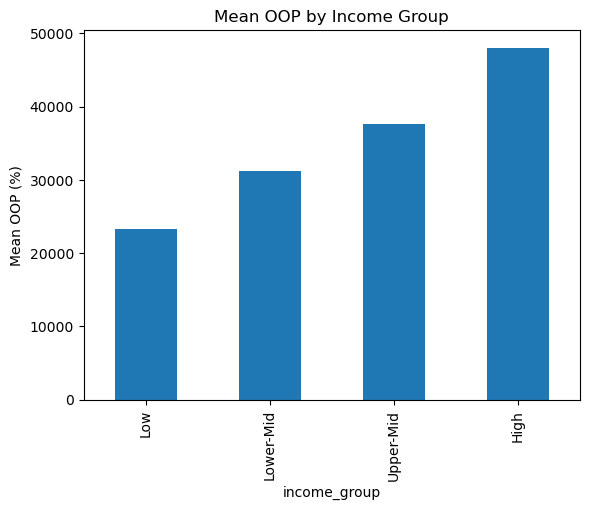

income_group
Low          23218.479463
Lower-Mid    31170.980821
Upper-Mid    37679.977759
High         48052.518012
Name: oop_pct, dtype: float64

In [74]:
# quartiles based on log of GDP
df['income_group'] = pd.qcut(df['log_gdp_pc'], 4, labels=['Low', 'Lower-Mid', 'Upper-Mid', 'High'])

# mean Out Of Pocket spending for each group
income_oop = df.groupby('income_group')['oop_pct'].mean()

income_oop.plot(kind='bar')
plt.ylabel('Mean OOP (%)')
plt.title('Mean OOP by Income Group')
plt.show()

income_oop


Countries were split into four income groups based on log GDP. The mean OOP burden declines as income rises. The lowest-income group has the highest OOP share, and each step up the income scale reduces the burden. The pattern is monotonic, which supports the earlier regression results: higher income reduces reliance on out-of-pocket spending. The top income group records the lowest OOP share, indicating stronger financial protection and public coverage.

### 3. Does Personal spending of households change over time?

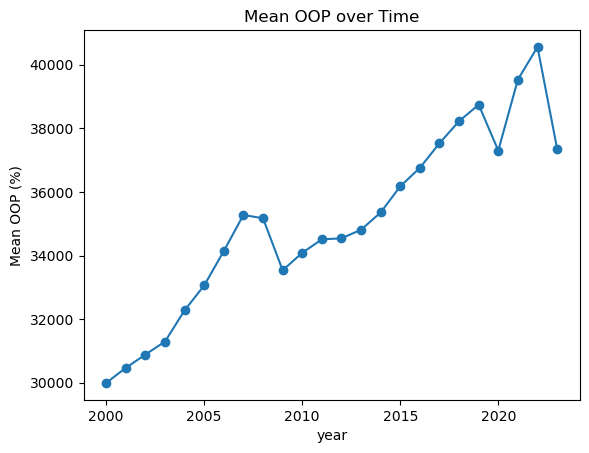

year
2000    29995.271249
2001    30469.366080
2002    30887.504198
2003    31295.714407
2004    32278.528360
2005    33061.965672
2006    34143.017222
2007    35276.507786
2008    35171.642684
2009    33537.024394
2010    34086.098907
2011    34509.430242
2012    34542.374526
2013    34810.774566
2014    35354.357423
2015    36176.527461
2016    36757.762307
2017    37532.373905
2018    38225.379623
2019    38742.229592
2020    37300.379622
2021    39533.248551
2022    40559.886597
2023    37362.801354
Name: oop_pct, dtype: float64

In [75]:
# Mean of Out Of Pocket spending per year
oop_year = df.groupby('year')['oop_pct'].mean()

oop_year.plot(kind='line', marker='o')
plt.ylabel('Mean OOP (%)')
plt.title('Mean OOP over Time')
plt.show()

oop_year


Mean OOP spending varies over time. The trend is not linear, but periods with higher average government spending tend to coincide with lower OOP. The year-to-year fluctuations likely reflect policy changes and macro conditions. Despite volatility, the overall pattern is consistent with the main finding: stronger public financing reduces the individual financial burden.

## Key Findings

    * OOP spending falls as income rises and as governments allocate more resources to health.
    * All models show the same direction and significance, and results remain valid under robust inference.
    * Lower-income groups carry the highest OOP burden; high-income systems have stronger protection.
    * Year-to-year variation reflects shifts in public financing rather than random fluctuations.
    * The central pattern is consistent: stronger public funding reduces direct household payments.

**Future work**

    * Study the effect of insurance alongside current indicators.
    * Extend the scope of study by studying the effect on countries outside OECD
    * Study the quality of healthcare of a country and its GDP.

**References :** 
1. "https://pypi.org/project/wbgapi/" - python lib for world bank api
2. "https://pandasdmx.readthedocs.io/en/v1.0/"  - python lib for OECD
3. "https://www.geeksforgeeks.org/python/python-pandas-melt/" - melting dataset in python
4. "https://towardsdatascience.com/lowess-regression-in-python-how-to-discover-clear-patterns-in-your-data-f26e523d7a35/" - LOWESS (Locally Weighted Scatterplot Smoothing) regression.
5. "https://python-graph-gallery.com/web-minimalist-black-and-white-line-chart/" - Line Chart